<a href="https://colab.research.google.com/github/Mmiglio/SpeechRecognition/blob/Attention-Mechanism-and-Memory-Networks/notebooks/Rnn_Autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip -q install python_speech_features

In [2]:
!pip install -q tensorflow-gpu==2.0.0-beta1

     |████████████████████████████████| 348.9MB 65kB/s 
     |████████████████████████████████| 3.1MB 34.5MB/s 
     |████████████████████████████████| 501kB 48.7MB/s 


In [3]:
import tensorflow as tf

print("GPU Available: ", tf.test.is_gpu_available())
print("Version: ", tf.__version__)

GPU Available:  True
Version:  2.0.0-beta1


##  Get Scripts

In [0]:
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/getData.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/constants.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/trainingUtils.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/models.py
!wget -q https://raw.githubusercontent.com/Mmiglio/SpeechRecognition/Attention-Mechanism-and-Memory-Networks/src/analysisFunctions.py

## Download Data

In [5]:
from getData import downloadSpeechData, getDataDict

# Download data
downloadSpeechData(data_path='speechData/')

# Get dict with files and labels
dataDict = getDataDict(data_path='speechData/')

Extracting /content/speechData/train.tar.gz into /content/speechData/train
Extracting /content/speechData/test.tar.gz into /content/speechData/test


In [6]:
from getData import getDataframe

trainDF = getDataframe(dataDict['train'])
valDF = getDataframe(dataDict['val'], include_unknown=False)
testDF = getDataframe(dataDict['test'], include_unknown=False) 
finalTestDF = getDataframe(dataDict['finalTest'], include_unknown=False)

print("Train files: {}".format(trainDF.shape[0]))
print("Validation files: {}".format(valDF.shape[0]))
print("Test files: {}".format(testDF.shape[0]))
print("Final test files: {}".format(testDF.shape[0]))

Train files: 51088
Validation files: 6798
Test files: 6835
Final test files: 6835


In [0]:
from trainingUtils import getDatasetAutoencoder

BATCH_SIZE = 32
# Reduced trainign dataset
NUM_EXAMPLES = 20000

train_data, train_steps = getDatasetAutoencoder(
    df=trainDF[:NUM_EXAMPLES],
    batch_size=BATCH_SIZE,
    cache_file='train_denoising_autoencoder_cache',
    shuffle=True,
    add_noise=True,
    scale=True
) 

val_data, val_steps = getDatasetAutoencoder(
    df=valDF,
    batch_size=BATCH_SIZE,
    cache_file='val_denoising_autoencoder_cache',
    shuffle=False,
    add_noise=False,
    scale=True
)

## Autoencoder

In [0]:
def en_dec_rnn(input_shape=(99, 40)):
    '''
    Encoder/Decoder RNN
    
    Parameters\n
    input_shape (array): dimensions of the model input\n
    '''
#     # Fetch input
#     inputs = tf.keras.Input(shape=input_shape)
#     reshape = tf.keras.layers.Reshape(
#         input_shape=input_shape, target_shape=(99, 40, 1))(inputs)

#     # Normalization Layer
#     layer_out = tf.keras.layers.BatchNormalization()(reshape)

#     # Convolutional Layer
#     layer_out = tf.keras.layers.Conv2D(30, kernel_size=(3, 3),
#                                        padding='same', activation='relu')(layer_out)
#     layer_out = tf.keras.layers.BatchNormalization()(layer_out)
#     layer_out = tf.keras.layers.Conv2D(1, kernel_size=(3, 3),
#                                        padding='same', activation='relu')(layer_out)
#     layer_out = tf.keras.layers.BatchNormalization()(layer_out)
#     layer_out = tf.keras.layers.Lambda(
#         lambda x: tf.keras.backend.squeeze(x, -1), name='squeeze_dim')(layer_out)

#     # Encoding Layer
#     encoder = tf.keras.layers.LSTM(60, activation='relu', name='Encoder')(layer_out)

#     # Decoding Layer
#     decoder = tf.keras.layers.RepeatVector(99)(encoder)
#     decoder = tf.keras.layers.LSTM(60, activation='relu', return_sequences=True)(decoder)
#     decoder = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(40))(decoder)



#     model = tf.keras.Model(inputs=[inputs], outputs=[decoder])
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.LSTM(128, activation='relu', input_shape=input_shape, return_sequences=True))
    model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=False))
    model.add(tf.keras.layers.RepeatVector(99))
    model.add(tf.keras.layers.LSTM(64, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.LSTM(128, activation='relu', return_sequences=True))
    model.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(40)))
    return model 

In [89]:
model = en_dec_rnn()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_13 (LSTM)               (None, 99, 128)           86528     
_________________________________________________________________
lstm_14 (LSTM)               (None, 64)                49408     
_________________________________________________________________
repeat_vector_8 (RepeatVecto (None, 99, 64)            0         
_________________________________________________________________
lstm_15 (LSTM)               (None, 99, 64)            33024     
_________________________________________________________________
lstm_16 (LSTM)               (None, 99, 128)           98816     
_________________________________________________________________
time_distributed_8 (TimeDist (None, 99, 40)            5160      
Total params: 272,936
Trainable params: 272,936
Non-trainable params: 0
________________________________________________

In [10]:
!rm train_den* val_den*

rm: cannot remove 'train_den*': No such file or directory
rm: cannot remove 'val_den*': No such file or directory


In [0]:
model.compile(loss='mse', 
              optimizer=tf.keras.optimizers.Adam()
             )

In [91]:
EPOCHS = 80

# Stop if the validation accuracy doesn't imporove for 5 epochs
earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=8, verbose=1)

# Reduce LR on Plateau
reduceLR = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=3, verbose=1)

# Save best models
modelCheckpoint = tf.keras.callbacks.ModelCheckpoint("bestRNNAE.h5",  monitor='val_loss', save_best_only=True)

history = model.fit(train_data.repeat(), 
          steps_per_epoch=train_steps,
          validation_data=val_data.repeat(),
          validation_steps=val_steps,
          epochs=EPOCHS,
          callbacks=[earlyStopping, reduceLR, modelCheckpoint])

Epoch 1/80
625/625 [==============================] - 590s 944ms/step - loss: 765188082118.3766 - val_loss: 1.0004
Epoch 2/80
625/625 [==============================] - 584s 935ms/step - loss: 1.0004 - val_loss: 1.0004
Epoch 3/80
625/625 [==============================] - 582s 931ms/step - loss: 1.0004 - val_loss: 1.0004
Epoch 4/80
624/625 [============================>.] - ETA: 0s - loss: 1.0004
Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
625/625 [==============================] - 581s 930ms/step - loss: 1.0004 - val_loss: 1.0004
Epoch 5/80
625/625 [==============================] - 581s 930ms/step - loss: 1.0004 - val_loss: 1.0004
Epoch 6/80
625/625 [==============================] - 582s 932ms/step - loss: 1.0004 - val_loss: 1.0004
Epoch 7/80
624/625 [============================>.] - ETA: 0s - loss: 1.0004
Epoch 00007: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
625/625 [==============================] - 582s 932ms/step -

KeyboardInterrupt: ignored

In [0]:
model.save("RNNAE.h5")

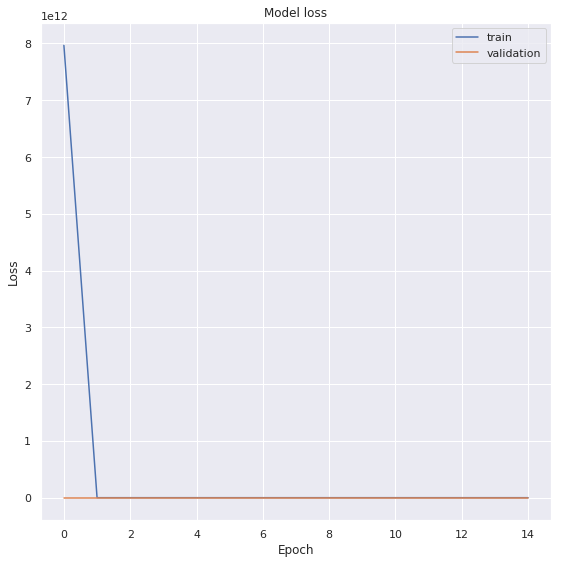

In [66]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
import seaborn as sns 

sns.set()

loss = history.history['loss']
val_loss = history.history['val_loss']

fig, ax1 = plt.subplots(1,1, figsize=(8,8))

ax1.plot(loss, label='train')
ax1.plot(val_loss, label='validation')
ax1.xaxis.set_major_locator(MaxNLocator(integer=True))
ax1.set_title('Model loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()

plt.tight_layout()
fig.show()

In [67]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
!mkdir /content/gdrive/My\ Drive/Colab\ Notebooks/RNNAutoencoders

In [68]:
GDRIVE_PATH = "/content/gdrive/My Drive/Colab Notebooks/RNNAutoencoders/"

model.save(GDRIVE_PATH +"RNNAE.h5")
print("Saved model to drive")

Saved model to drive


In [69]:
import pickle
## Save history data
with open(GDRIVE_PATH + "train_results.pickle", "wb") as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)    
print("Saved training history to drive")

Saved training history to drive


## Test 

In [0]:
from tensorflow.keras.models import load_model

autoencoder = load_model("bestRNNAE.h5")

In [0]:
from trainingUtils import _loadWavs, _logMelFilterbank, getDataset, _scale
from python_speech_features import mfcc
import numpy as np

def _parse_fn_autoencoder_test(filename, label, nfilt=40, add_noise=True, scale=True):
    """
    Function used to compute filterbanks from file name
    """
    wave = _loadWavs(filename)
    fbank = _logMelFilterbank(wave, nfilt)
    #fbank = mfcc(wave)
    
    if scale:
        fbank = _scale(fbank)
    
    input_image = fbank
    if add_noise:
        input_image = fbank + 0.2*np.random.normal(0, 1, fbank.shape)
        
    return input_image, fbank

In [73]:
from trainingUtils import _parse_fn_autoencoder
image_noise, image = _parse_fn_autoencoder_test(testDF['files'][100], testDF['files'][100])
print(image_noise.shape)
denoised = model.predict(image_noise.reshape((1, 99, 40))).reshape(99, 40)

(99, 40)


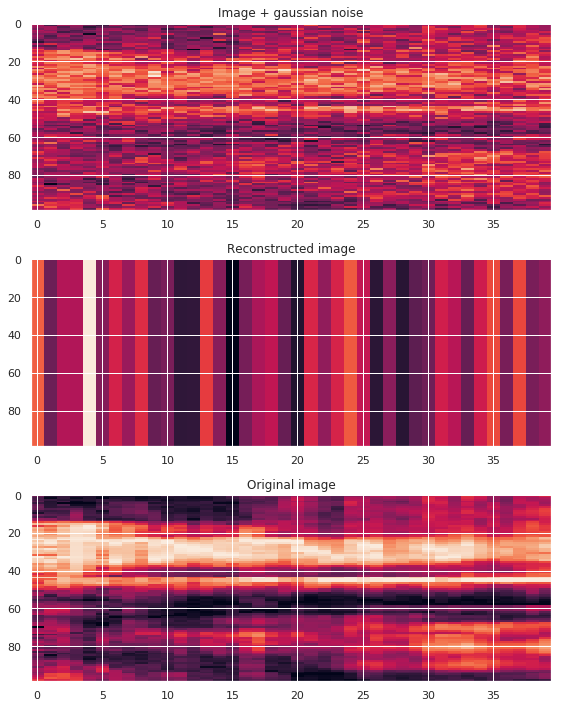

In [74]:
fig, (ax1, ax2, ax3) = plt.subplots(3,1, figsize=(8,10))

ax1.imshow(image_noise, aspect="auto")
ax1.set_title("Image + gaussian noise")

ax2.imshow(denoised, aspect="auto")
ax2.set_title("Reconstructed image")

ax3.imshow(image, aspect="auto")
ax3.set_title("Original image")

plt.tight_layout()
plt.show()

In [0]:
def getFeatures(model, data):
    layer_name = 'Encoder'
    layer_out = tf.keras.Model(inputs=model.input, outputs=model.get_layer(layer_name).output)
    return layer_out.predict(data, use_multiprocessing=True)